# Fraud Detection Project

This notebook includes:
- Data loading and exploration
- Feature engineering
- Baseline and LightGBM/XGBoost modeling
- Evaluation metrics and plots
- Insights and business recommendations


📓 Cell 1 — Setup & Imports

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import lightgbm as lgb

import joblib


In [2]:
df = pd.read_csv('/content/Fraud.csv')
print(df.shape)
df.head()
df.info()


(83561, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83561 entries, 0 to 83560
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            83561 non-null  int64  
 1   type            83561 non-null  object 
 2   amount          83561 non-null  float64
 3   nameOrig        83561 non-null  object 
 4   oldbalanceOrg   83560 non-null  float64
 5   newbalanceOrig  83560 non-null  float64
 6   nameDest        83560 non-null  object 
 7   oldbalanceDest  83560 non-null  float64
 8   newbalanceDest  83560 non-null  float64
 9   isFraud         83560 non-null  float64
 10  isFlaggedFraud  83560 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 7.0+ MB


📓 Cell 2 — Load Data

isFraud
0.0    0.99866
1.0    0.00134
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Transaction Types and Fraud')

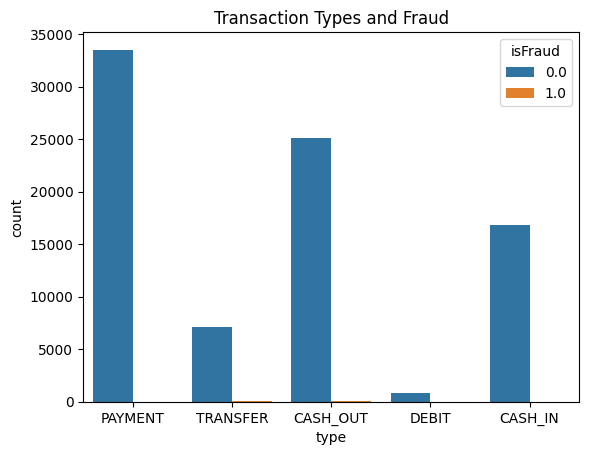

In [3]:
# Class balance
print(df['isFraud'].value_counts(normalize=True))

# Visualize transaction types by fraud
sns.countplot(data=df, x='type', hue='isFraud')
plt.title('Transaction Types and Fraud')


📓 Cell 3 — EDA

In [6]:
# Check how many NaNs in target
print("Missing values in y:", y.isnull().sum())

# Drop rows where target is NaN
df_model = df_model.dropna(subset=['isFraud'])

# Define features and target again
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Proceed with train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Missing values in y: 1


📓 Cell 4 — Data Cleaning & Feature Engineering

In [7]:
# Check how many NaNs in target
print("Missing values in y:", y.isnull().sum())

# Drop rows where target is NaN
df_model = df_model.dropna(subset=['isFraud'])

# Define features and target again
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Proceed with train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Missing values in y: 0


📓 Cell 5 - Baseline Model

In [8]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94     16690
         1.0       0.01      0.86      0.02        22

    accuracy                           0.89     16712
   macro avg       0.51      0.88      0.48     16712
weighted avg       1.00      0.89      0.94     16712

ROC AUC: 0.9385424042703849


📓 Cell 6 — Advanced Models with Hyperparameter Tuning

In [9]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1], use_label_encoder=False, eval_metric='auc')
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1]
}

xgb_search = RandomizedSearchCV(xgb_clf, param_dist, n_iter=10, scoring='roc_auc', cv=3, verbose=1, random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)

print("Best Params:", xgb_search.best_params_)
y_pred_xgb = xgb_search.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, xgb_search.predict_proba(X_test)[:,1]))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:38:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16690
         1.0       0.71      0.77      0.74        22

    accuracy                           1.00     16712
   macro avg       0.85      0.89      0.87     16712
weighted avg       1.00      1.00      1.00     16712

ROC AUC: 0.9975842910833924


In [10]:
lgb_clf = lgb.LGBMClassifier(class_weight='balanced')
param_dist_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1]
}

lgb_search = RandomizedSearchCV(lgb_clf, param_dist_lgb, n_iter=10, scoring='roc_auc', cv=3, verbose=1, random_state=42, n_jobs=-1)
lgb_search.fit(X_train, y_train)

print("Best Params:", lgb_search.best_params_)
y_pred_lgb = lgb_search.predict(X_test)
print(classification_report(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, lgb_search.predict_proba(X_test)[:,1]))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 90, number of negative: 66758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1801
[LightGBM] [Info] Number of data points in the train set: 66848, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16690
         1.0       0.85      0.77      0.81        22

    accuracy                           1.00   

📓 Cell 7 - Evaluation Curves & Feature Importance

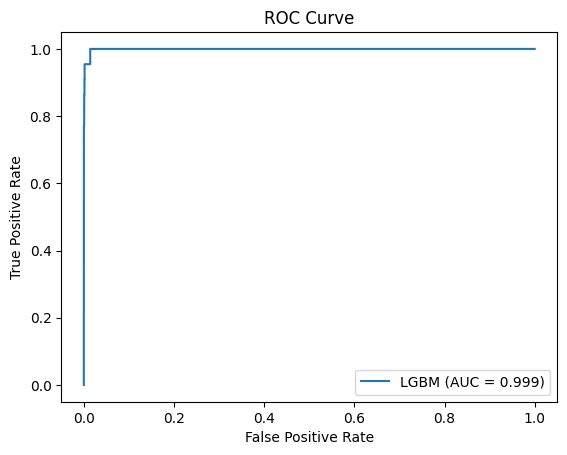

Text(0.5, 1.0, 'Top 15 Feature Importances - LightGBM')

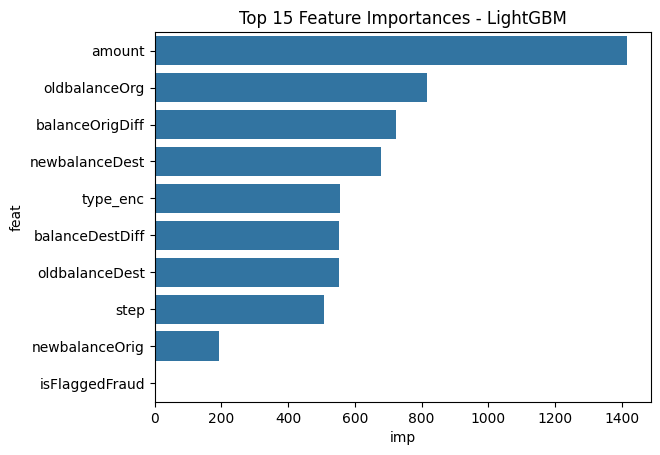

In [11]:
# ROC curve (example)
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

probs = lgb_search.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label='LGBM (AUC = %.3f)' % auc(fpr,tpr))
plt.legend()
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.show()

# Feature importance
imp = pd.DataFrame({'feat': X_train.columns, 'imp': lgb_search.best_estimator_.feature_importances_})
imp = imp.sort_values('imp', ascending=False).head(15)
sns.barplot(x='imp', y='feat', data=imp)
plt.title('Top 15 Feature Importances - LightGBM')


📓 Cell 8 — Save Models

In [12]:
joblib.dump(xgb_search.best_estimator_, 'xgb_model.pkl')
joblib.dump(lgb_search.best_estimator_, 'lgb_model.pkl')


['lgb_model.pkl']